<a href="https://colab.research.google.com/github/tools-only/fastai/blob/master/lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fast.ai学习笔记：Lesson1 - Image classification**

这节课主要学习了如何将预训练模型部署到自己的学习任务中，如何进行Fine-tuning等内容。

在jupyter notebook中，使用魔术命令(magic command)自动重新加载更改的模块，即如果在调试过程中代码发生更新，jupyter notebook中引用的模块也将自动更新。  
detail：  
%autoreload:  自动重载%aimport排除的模块之外的所有模块。 
%autoreload 0: 禁用自动重载。  
%autoreload 1: 自动重载%aimport指定的模块。   
**%autoreload 2: 自动重载%aimport排除的模块之外的所有模块。**  
%aimport: 列出需要自动重载的模块和不需要重载的模块。  
%aimport foo: 重载模块foo并将它标记为需要自动重载。  
%aimport -foo: 将模块foo标记为不需要自动重载。  

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

载入fastai模块

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

设置batch_size

In [0]:
bs = 64

## 数据介绍
采用Oxford-IIIT Pet Dataset，数据集中包含12种猫的图片和25种狗的图片。模型将学习区分这37个不同的类别。参考该数据集的论文，当时（2012年）作者训练了一个复杂的模型，对图片分别使用”Image“、”Head“、”Body“模型，组合后准确率为59.21%。   
### 下载数据集
利用untar_data函数下载数据集，并对数据集进行简单的分析，具体包括：目录查看、图像查看、label存储方式

In [6]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [9]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [10]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

由于这里图像的label直接作为图片文件名进行存储的，因此需要从文件名中提取label。fastai库中提供了ImageDataBunch.from_name_re函数，利用正则表达式来提取图像的label。

In [13]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_166.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_155.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_159.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_197.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_156.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [18]:
help(ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path:Union[pathlib.Path, str], fnames:Collection[pathlib.Path], pat:str, valid_pct:float=0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



get_transforms函数其中一个作用就是将图像大小转换为224

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

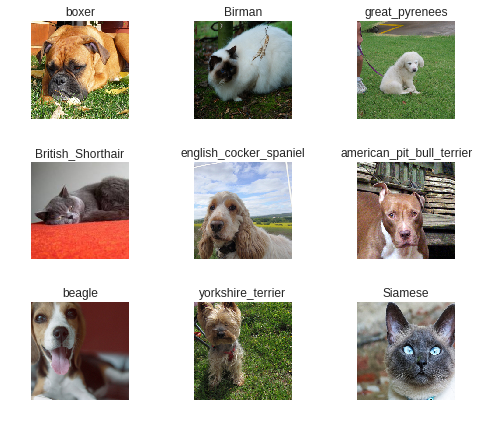

In [20]:
data.show_batch(rows=3, figsize=(7,6))

In [21]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,japanese_chin,chihuahua,keeshond,beagle
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Russian_Blue,chihuahua,american_pit_bull_terrier,shiba_inu,english_setter
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

#### 数据分析
训练集大小：5912  
校验集大小：1478  
测试集大小：None
图像规格 (x)：(3, 224, 224)   
label规格 (y)：37种

In [24]:
print(data.classes)
len(data.classes), data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## 训练Resnet34模型
Resnet34是一个卷积神经网络，细节待学习。   
注意这里使用的Resnet34是一个预训练模型，即Resnet34模型的初始权值是在imagenet上训练后的权值。

In [26]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 30488904.78it/s]


In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

**learning rate**是深度学习中非常重要的一个超参数，因此其大小决定了反向传播的梯度，反过来决定了模型损失函数走向最小值的程度，如果learning rate设置太小，则模型收敛速度慢；设置太大，则会使模型发散无法收敛。   
这里fastai集成了[one cycle policy](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6)用于调整learning rate。 One cycle policy的思想是，从一个较小的learning rate(如1e-4)开始，在每个小批量训练之后提高learning rate的值，直到损失开始爆炸。一旦出现损失爆炸的情况，停止范围测试，绘制learning rate-loss图，并选择比损失最小的学习率低一个数量级的learning rate(即损失最小时的learning rate为0.1，则较好的learning rate初始值为0.01)。  
这里函数参数epoch次数设置为4。

In [28]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.360133,0.315292,0.086604
2,0.573985,0.224301,0.075778
3,0.357509,0.201987,0.070365
4,0.253277,0.192459,0.062923


In [0]:
learn.save('stage-1')

## 训练结果
首先看看模型最容易犯错的类别是哪些，并检查这些错误是合理的还是非常离谱的。

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

注意到，如果模型以很高的置信度将某张图像识别错误，那么对应的损失值将很大。因此，接下来输出模型在校验集上损失最大的前9张图片。  
通过doc(interp.plot_top_losses)可以了解到输出图像上方数值所对应的意义，以第一张图像为例：  
模型预测label为boxer，而真实label为saint_bernard，损失值为7.33，模型预测该图像为saint_bernard(真实label)的概率为0.00。

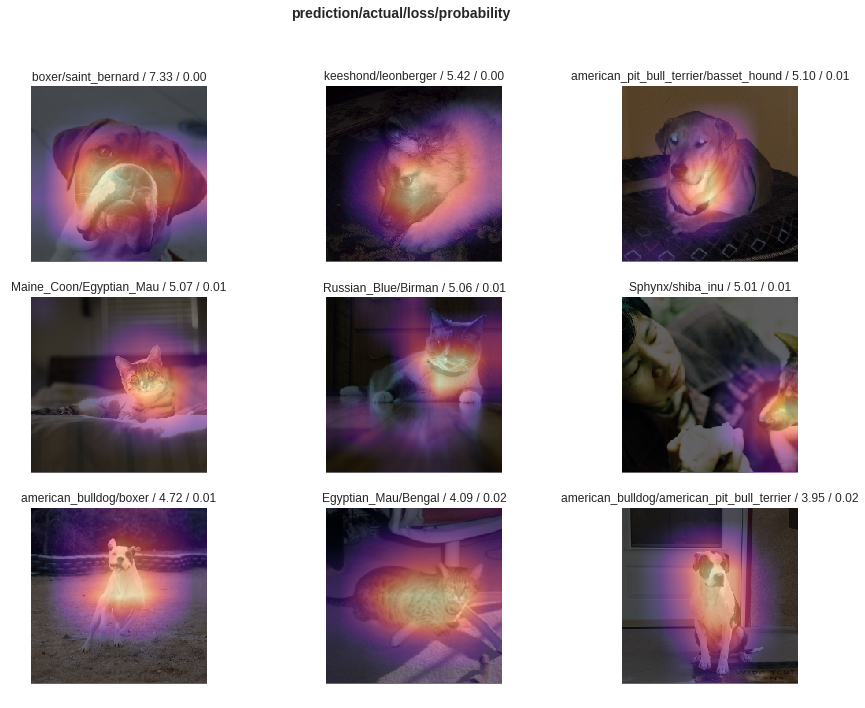

In [33]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

输出混淆矩阵，由于这里类别较多，可视化效果较差，推荐学习者使用most_confused函数，仅仅输出混淆次数最多的类别。

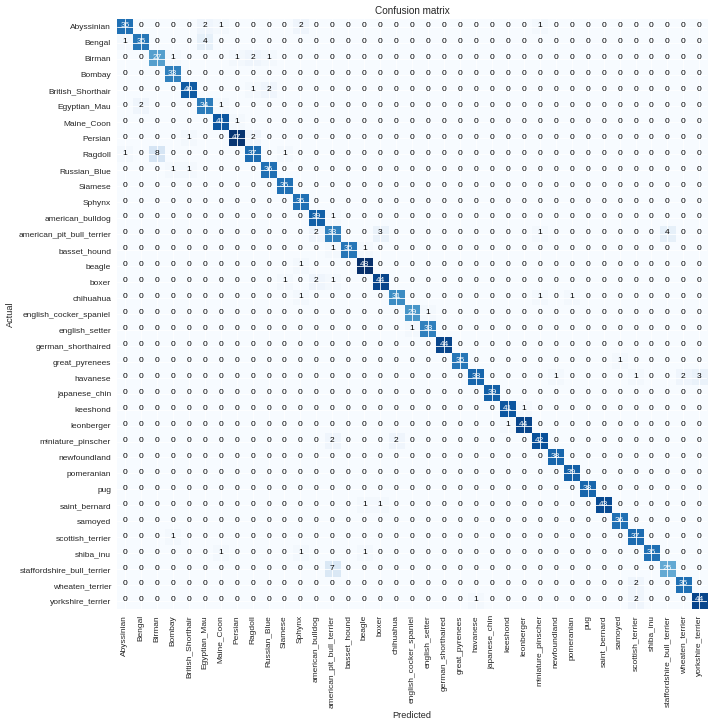

In [37]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

输出混淆次数最多的类别组合，具体的解读如下：  
('Ragdoll', 'Birman', 8)：真实label为Ragdoll，然而模型预测label为Birman，这种情况共出现了8次。 

In [38]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 8),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Bengal', 'Egyptian_Mau', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('american_pit_bull_terrier', 'boxer', 3),
 ('havanese', 'yorkshire_terrier', 3)]

## Fine-tuning
经过训练之后，我们的模型已经能够达到接近99.4%的分类准确率了。这是因为采用的Resnet34模型是经过了Imagenet预训练的，在这里的识别猫狗任务中，实际训练只是针对模型后面部分层次（较深卷积层）进行权重更新。 因此，模型训练时间也相对较快 (然而，colab尽管是免费，却只会分配部分卡，导致计算资源实在匮乏。。   
这里采用unfreeze函数之后，重新训练模型。相当于将整个模型进行重训练，而不是有意偏向于更新模型较深的层次。这种"公正"的梯度更新策略，并非能够提升模型的训练效果，反而降低了分类准确率。   
可以看到，error_rate明显比之前训练的结果要大一个数量级。视频中Jeremy Howard利用论文[《Visualizing and Understanding Convolutional Networks》](https://arxiv.org/abs/1311.2901)中的插图讲述了卷积神经网络中每个层所学习到的特征，可以发现随着层次的加深，模型学习到的特征也是由浅入深，因此，在直观上可以感受到，如果要对模型进行调节，我们更期望调节模型的最后一层卷积层（由于较浅层提取的特征尚不能刻画图片的整体特征）。   

In [0]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.516928,0.357237,0.110284


载入之前训练较好的模型'stage-1'

In [41]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,japanese_chin,chihuahua,keeshond,beagle
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Russian_Blue,chihuahua,american_pit_bull_terrier,shiba_inu,english_setter
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kerne

接下来绘制LR-Loss图，可以发现当LR超过1e-04时，损失开始提升，说明损失开始发散。

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06


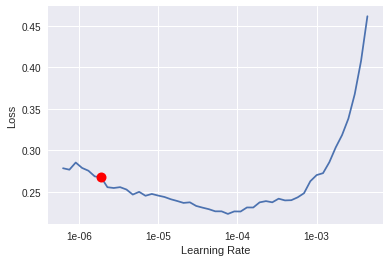

In [43]:
learn.recorder.plot()

In [44]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.231169,0.187222,0.060893
2,0.204607,0.182796,0.057510


可以看到，在调整了LR之后，模型的准确率较之前（0.062923）有了一些提升。